In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as M
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython import display

from lateral_connections import LateralModel, VggModel, CustomImageDataset

import PIL as pillow
import torchvision
from torchvision.datasets import MNIST, Omniglot

"""
def transform_pillow_to_torch(x):
    #x = x.resize((224,224), resample=pillow.Image.BILINEAR).convert('RGB')
    #return torchvision.transforms.ToTensor()(x)
    return torchvision.transforms.ToTensor()(torchvision.transforms.Grayscale(num_output_channels=3)(x))

def plt_t(x):
    plt.imshow(torch.swapaxes(x,0,2))

mnist = MNIST('images/mnist/', download=True, transform=transform_pillow_to_torch)
omniglot = Omniglot('images/omniglot/', download=True, transform=transform_pillow_to_torch)
"""

"\ndef transform_pillow_to_torch(x):\n    #x = x.resize((224,224), resample=pillow.Image.BILINEAR).convert('RGB')\n    #return torchvision.transforms.ToTensor()(x)\n    return torchvision.transforms.ToTensor()(torchvision.transforms.Grayscale(num_output_channels=3)(x))\n\ndef plt_t(x):\n    plt.imshow(torch.swapaxes(x,0,2))\n\nmnist = MNIST('images/mnist/', download=True, transform=transform_pillow_to_torch)\nomniglot = Omniglot('images/omniglot/', download=True, transform=transform_pillow_to_torch)\n"

In [24]:
device = torch.device('cuda')

dataset = 'mnist'

def transform_data(x):
    x = torchvision.transforms.ToTensor()(x)
    return x

def transform_corrupt(x):
    x = torchvision.transforms.ToTensor()(x)
    x[:, :x.shape[1]//2, :] = torch.median(x)
    return x

if dataset == 'mnist':
    num_classes = 10
    train_data = torchvision.datasets.MNIST('images/mnist/', train=True, transform=transform_data, download=True)
    test_data = torchvision.datasets.MNIST('images/mnist/', train=False, transform=transform_corrupt, download=True)

elif dataset == 'omniglot':
    num_classes = 964
    train_data = torchvision.datasets.Omniglot('images/mnist/', background=True, transform=transform_data, download=True)
    test_data = torchvision.datasets.Omniglot('images/mnist/', background=False, transform=transform_corrupt, download=True)
    
print(train_data)
    
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=1),
    'test': torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True, num_workers=1)
}

print(loaders['train'])
print(train_data[0][0].shape)

Dataset MNIST
    Number of datapoints: 60000
    Root location: images/mnist/
    Split: Train
    StandardTransform
Transform: <function transform_data at 0x7f4319628280>
torch.Size([1, 28, 28])


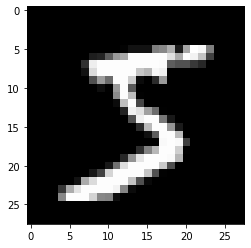

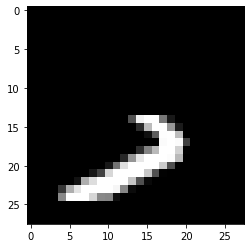

In [23]:
img, label = train_data[0]
plt.imshow(img[0,...], cmap='gray')
plt.show()

img2 = torch.clone(img)
img2[:, :img2.shape[1]//2, :] = torch.median(img2)
plt.imshow(img2[0,...], cmap='gray')

In [25]:
import torch.nn as nn
from torch import optim

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        
        # TODO: Fix for datasets
        if num_classes == 10:
            self.out = nn.Linear(32 * 7 * 7, num_classes)
        else:
            self.out = nn.Linear(32 * 26 * 26, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization
    
model = SimpleCNN(num_classes)
loss_func = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr = 0.01)  
model.to(device)

print(model)

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [26]:
num_epochs = 5

def train(num_epochs, model, loaders, loss_func):
    model.train()
    
    total_step = len(loaders['train'])
    
    for epoch in tqdm(range(num_epochs), leave=False):
        
        correct = 0
        total = 0
        total_loss = 0
        
        
        for i, (images, labels) in tqdm(enumerate(loaders['train'], 0), total=len(loaders['train'])):
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)[0]
            
            pred_y = torch.max(output, 1)[1].data.squeeze()             
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)
            
            loss = loss_func(output, labels)
            total_loss += (loss.item() / total)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1:2d}\tLoss: {round(total_loss,4):1.4f}\tAccuracy: {round(correct/total,4):1.4f}")
            
            
train(num_epochs, model, loaders, loss_func)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  1	Loss: 0.0661	Accuracy: 0.9375


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  2	Loss: 0.0039	Accuracy: 0.9789


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  3	Loss: 0.0028	Accuracy: 0.9815


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  4	Loss: 0.0024	Accuracy: 0.9822


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch  5	Loss: 0.0025	Accuracy: 0.9840


In [27]:
def test(eval_mode='test'):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in tqdm(loaders[eval_mode]):
            images = images.to(device)
            labels = labels.to(device)
            
            test_output, last_layer = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            
            total += labels.size(0)
            correct += (pred_y == labels).sum().item()
            
        accuracy = correct / total
        if eval_mode == 'test':
            print('Test Accuracy is ', round(accuracy,4))
        elif eval_mode == 'train':
            print('Train Accuracy is ', round(accuracy,4))
        
test('train')
test()

  0%|          | 0/469 [00:00<?, ?it/s]

Train Accuracy is  0.9872


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy is  0.3924
